In [1]:
import itertools
import json
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

In [2]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = [None, "MNLI", "QQP", "RTE", "SNLI"]#"MRPC", "CoLA", "MNLI", "RTE", "SST", "WNLI", "SNLI", "QQP"]
checkpoint_steps = [1000, 2000, 3000, 4000, 5000]
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-5000"

In [3]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {
    None: {
        "first_loss": None,
        "steps": {}
    }
}

for model in bert_models:
    if model not in model_metadata:
        model_metadata[model] = {"steps": {}}
    print(model)
        
    # brain decoding results for each checkpoint step
    for checkpoint_step in checkpoint_steps:
        decoding_perf_path = "perf.384sentences.bert.base%s.csv" % \
            ("" if model is None else ".%s-%s-%d" % (finetune_desc, model, checkpoint_step))
        decoding_perf = pd.read_csv(decoding_perf_path, index_col=[0, 1])
        model_metadata[model]["steps"][checkpoint_step] = {
            "decoding_mean": decoding_perf.loc["ridge"].mean().mean(),
            "decoding_std": decoding_perf.loc["ridge"].mean(axis=1).std()
        }
    
    # global model data -- read from checkpoint
    from tensorflow.python.pywrap_tensorflow import NewCheckpointReader
    if model is None:
        model_dir = bert_path / bert_base_model
    else:
        # DEV finetune-bk
        model_dir = bert_path / ("finetune-5000.bk/%s.%s.%s" % (finetune_desc, bert_base_model, model))
    try:
        ckpt = NewCheckpointReader(str(model_dir / "model.ckpt"))
    except:
        ckpt = NewCheckpointReader(str(model_dir / ("model.ckpt-%i" % checkpoint_steps[-1])))
        
    if model is not None:
        model_metadata[model]["global_steps"] = ckpt.get_tensor("global_step")
        
        # Also get the size of the output space -- for analyzing loss values across different tasks
        model_metadata[model]["output_dims"] = ckpt.get_tensor("output_bias").shape[0]
        
    # training events data
    import tensorflow as tf
    try:
        events_file = next(model_dir.glob("events.*"))
    except StopIteration:
        # no events data -- skip
        pass
    else:
        total_global_norm = 0.
        first_loss, cur_loss = None, None
        tags = set()
        for e in tf.train.summary_iterator(str(events_file)):
            for v in e.summary.value:
                tags.add(v.tag)
                if v.tag == "grads/global_norm":
                    total_global_norm += v.simple_value
                elif v.tag == "loss_1":
                    if e.step == 1:
                        first_loss = v.simple_value
                    cur_loss = v.simple_value
                    
            if e.step in checkpoint_steps:
                model_metadata[model]["steps"][e.step].update({
                    "total_global_norms": total_global_norm,
                    "train_loss": cur_loss,
                    "train_loss_norm": cur_loss / model_metadata[model]["output_dims"]
                })
                
        model_metadata[model]["first_train_loss"] = first_loss
        model_metadata[model]["first_train_loss_norm"] = first_loss / model_metadata[model]["output_dims"]
        
    # eval events data
    try:
        eval_events_file = next(model_dir.glob("eval/events.*"))
    except StopIteration:
        # no eval events data -- skip
        pass
    else:
        tags = set()
        eval_loss, eval_accuracy = None, None
        for e in tf.train.summary_iterator(str(eval_events_file)):
            for v in e.summary.value:
                tags.add(v.tag)
                if v.tag == "eval_loss":
                    eval_loss = v.simple_value
                elif v.tag == "eval_accuracy":
                    eval_accuracy = v.simple_value
                
            if e.step in checkpoint_steps:
                model_metadata[model]["steps"][e.step].update({
                    "eval_accuracy": eval_accuracy,
                    "eval_loss": eval_loss,
                })
        
print(tags)

None
MNLI
QQP
RTE
SNLI
{'loss', 'eval_loss', 'checkpoint_path', 'eval_accuracy'}


In [4]:
model_metadata

{None: {'first_loss': None,
  'steps': {1000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172},
   2000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172},
   3000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172},
   4000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172},
   5000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172}}},
 'MNLI': {'first_train_loss': 1.1093275547027588,
  'first_train_loss_norm': 0.36977585156758624,
  'global_steps': 5000,
  'output_dims': 3,
  'steps': {1000: {'decoding_mean': 119.72321428568404,
    'decoding_std': 32.205071006831105,
    'eval_accuracy': 0.75,
    'eval_loss': 0.5981411337852478,
    'total_global_norms': 76.03689575195312,
    'train_loss': 0.6182403564453125,
    'train_loss_norm': 0.20608011881510416},
   2000: {'decoding_mean': 121.37037037035624,
    'decoding_std': 31.73469815325164,
    'eval_accur

In [5]:
# Flatten model results into a single collection.
model_metadata_flat = []

for model, metadata in model_metadata.items():
    for step, step_data in metadata["steps"].items():
        model_metadata_flat.append((model, step, step_data["decoding_mean"], step_data["decoding_std"],
                                    metadata.get("first_train_loss", None), metadata.get("first_train_loss_norm", None),
                                    step_data.get("train_loss", None), step_data.get("train_loss_norm", None),
                                    step_data.get("total_global_norms", None),
                                    step_data.get("eval_loss"), step_data.get("eval_accuracy")))
        
df = pd.DataFrame(model_metadata_flat, columns=("model", "step", "decoding_mean", "decoding_std",
                                                "first_train_loss", "first_train_loss_norm", "train_loss", "train_loss_norm",
                                                "total_global_norms",
                                                "eval_loss", "eval_accuracy"))

In [6]:
df["train_loss_delta"] = df["train_loss"] - df["first_train_loss"]
df["train_loss_norm_delta"] = df["train_loss_norm"] - df["first_train_loss_norm"]
df

,model,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta
0,None,1000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,2000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,3000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,4000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,5000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MNLI,1000,119.723214,32.205071,1.109328,0.369776,0.618240,0.206080,76.036896,0.598141,0.750000,-0.491087,-0.163696
6,MNLI,2000,121.370370,31.734698,1.109328,0.369776,0.412830,0.137610,163.398146,0.533728,0.778750,-0.696497,-0.232166
7,MNLI,3000,120.375992,31.894846,1.109328,0.369776,0.403071,0.134357,233.413849,0.498751,0.793750,-0.706256,-0.235419
8,MNLI,4000,121.153439,31.530929,1.109328,0.369776,0.614082,0.204694,298.047881,0.481398,0.813750,-0.495245,-0.165082
9,MNLI,5000,120.405093,31.713670,1.109328,0.369776,0.532161,0.177387,368.065822,0.480202,0.810392,-0.577166,-0.192389


Text(0.5, 1.0, 'Decoding performance vs. total number of fine-tuning steps')

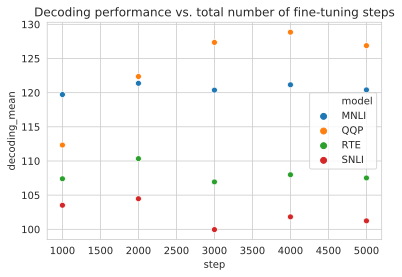

In [7]:
sns.scatterplot(data=df.reset_index(), y="decoding_mean", x="step", hue="model")
plt.title("Decoding performance vs. total number of fine-tuning steps")

Text(0.5, 1.0, 'Decoding performance vs. total global gradient norm')

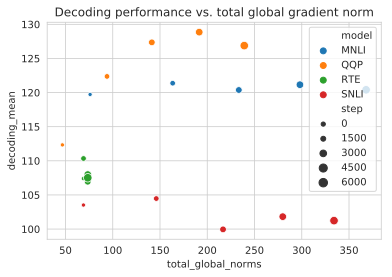

In [8]:
sns.scatterplot(data=df.reset_index(), y="decoding_mean", x="total_global_norms", hue="model", size="step")
plt.title("Decoding performance vs. total global gradient norm")

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Decoding performance vs. total global gradient norm')

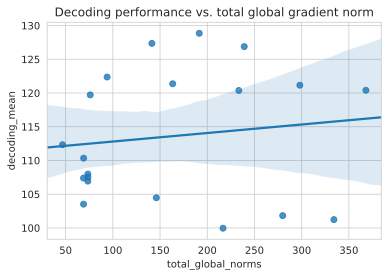

In [9]:
sns.regplot(data=df.reset_index(), y="decoding_mean", x="total_global_norms")
plt.title("Decoding performance vs. total global gradient norm")

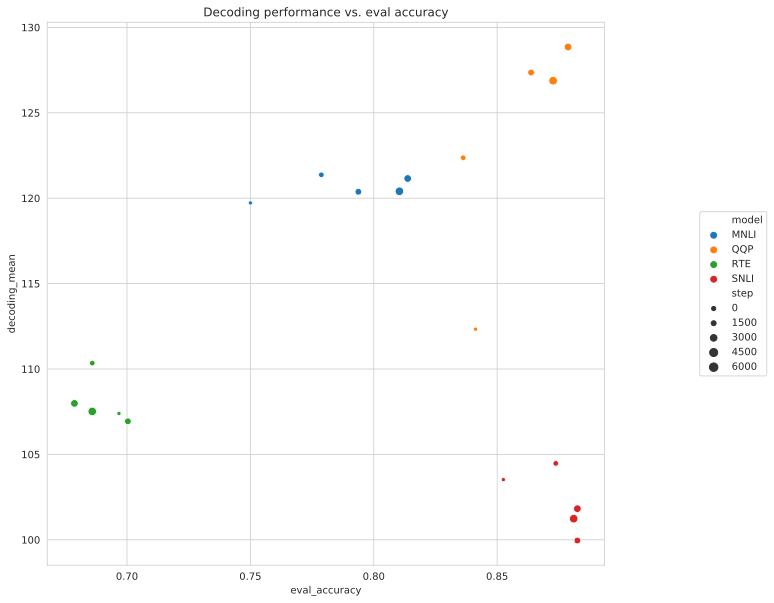

In [13]:
# NB: not directly comparable since the classification tasks have different output spaces
plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df.reset_index(), y="decoding_mean", x="eval_accuracy", hue="model", size="step")
plt.title("Decoding performance vs. eval accuracy")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(80, 150)

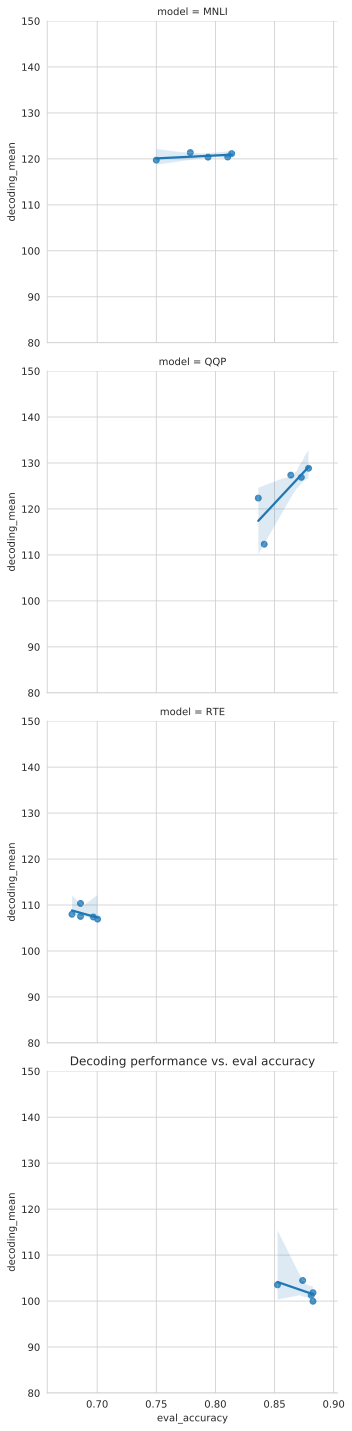

In [16]:
# NB: not directly comparable since the classification tasks have different output spaces
sns.lmplot(data=df.reset_index(), y="decoding_mean", x="eval_accuracy", row="model", truncate=True)
plt.title("Decoding performance vs. eval accuracy")
plt.ylim((80, 150))

## Transfer checks

      m1    m2         0
0   MNLI  MNLI  0.809475
1   MNLI   QQP  0.633663
2   MNLI   RTE  0.505415
3   MNLI  SNLI  0.429283
4    QQP  MNLI  0.350178
5    QQP   QQP  0.879817
6    QQP   RTE  0.534296
7    QQP  SNLI  0.422882
8    RTE  MNLI  0.349567
9    RTE   QQP  0.643532
10   RTE  SNLI  0.430096
11  SNLI  MNLI  0.349363
12  SNLI   QQP  0.634182
13  SNLI   RTE  0.476534


IndexError: single positional indexer is out-of-bounds

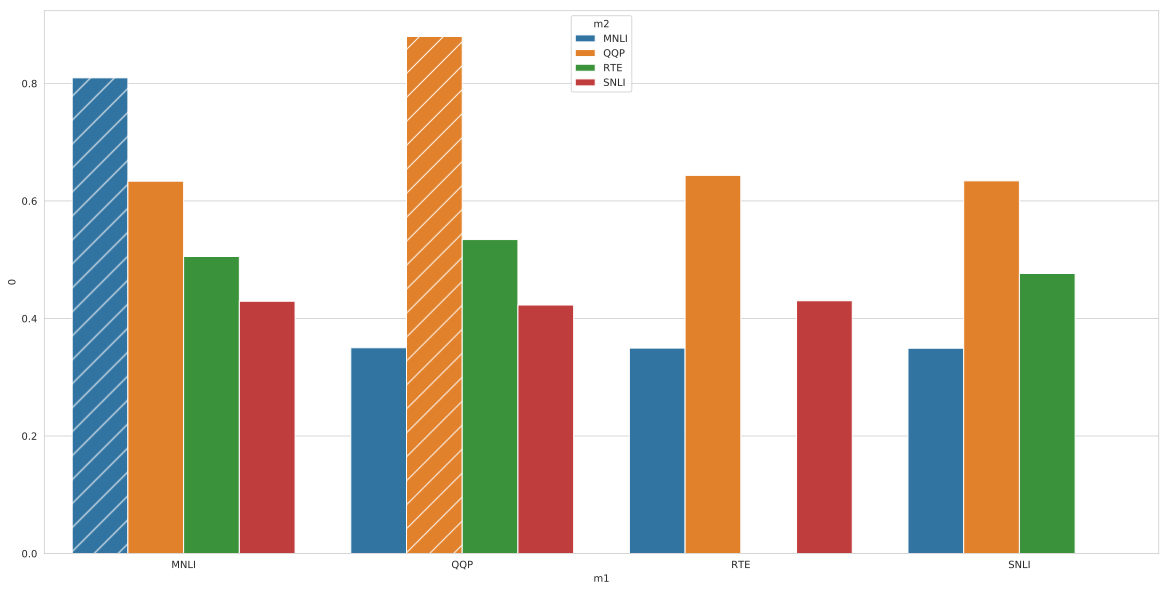

In [14]:
transfer_results = {}
for model in bert_models:
    # Get original fine-tune accuracy
    # TODO update "finetune" to `finetune_desc` once we have transfer data for the new limited finetune models
    results_path = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model)) / "eval_results.txt"
    if results_path.exists():
        with results_path.open("r") as results_f:
            acc, = re.findall(r"^eval_accuracy\s*=\s*([\d.-]+)$", results_f.read(), re.M)
            acc = float(acc)
            transfer_results[model, model] = acc
            
for m1, m2 in itertools.product(bert_models, repeat=2):
    results_path = bert_path / ("eval_transfer-%s" % finetune_desc) / ("results-%s-%s.json" % (m1, m2))
    if not results_path.exists():
        continue
        
    with results_path.open("r") as results_f:
        transfer_results[m1, m2] = json.load(results_f)["results"]["eval_accuracy"]

plt.subplots(figsize=(20, 10))
transfer_results = pd.Series(transfer_results)
transfer_results.index.rename(["m1", "m2"], inplace=True)
transfer_results = transfer_results.sort_index().reset_index()
print(transfer_results)

ax = sns.barplot(data=transfer_results, hue="m2", x="m1", y=0)
i = 0
for bar in sorted(ax.patches, key=lambda bar: bar.get_x()):
    row = transfer_results.iloc[i]
    if not np.isnan(bar.get_height()):
        if row.m1 == row.m2:
            bar.set_hatch("/")
            
        i += 1

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(data=pd.pivot_table(transfer_results, index="m1", columns="m2", values=0), annot=True)